In [140]:
import itertools
import os
import json
import copy
import sys
from collections import defaultdict
import itertools
import pandas as pd
from tqdm.notebook import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import seaborn as sns
import scipy.stats as stats
import pandas as pd
#import seaborn as sns
import seaborn as sns
from matplotlib import rcParams
import scipy
from scipy import stats
import seaborn as sns
from scipy import stats
import sys
import seaborn as sns
from utils import *
from sklearn.manifold import MDS

In [2]:
AVAILBLE_DATASETS = ['DIALOG_pc.csv','DIALOG_tc.csv','FLICKR.csv','MLQE.csv','REAL_SUM.csv',
                     'SUM_EVAL.csv','TAC_08.csv','TAC_09.csv','TAC_11.csv']
data_path = 'final_df'
ds_to_load = 'DIALOG_pc.csv'

In [3]:
count = 0
for ds in AVAILBLE_DATASETS:
    print('--------------------------------------')
    print( 'Loading DS',ds)
    considered_df = pd.read_csv(os.path.join(data_path,ds)).set_index(['System','Utterance'])
    print(considered_df.shape)
    count += considered_df.shape[0]*considered_df.shape[1]
    is_metric = ['H:' in i for i in considered_df.columns]
    human_metrics = []
    for index,i in enumerate(considered_df.columns):
        if is_metric[index]: 
            print('Human',i)
            human_metrics.append(i)
        else:
            pass
            print('Metric',i)
print('Number of points',count)

--------------------------------------
Loading DS DIALOG_pc.csv
(240, 19)
Human H:engaging
Human H:context
Human H:natural
Human H:overall
Human H:understandable
Human H:useknowledge
Metric S3_pyr
Metric S3_resp
Metric ROUGE_WE_1
Metric ROUGE_WE_2
Metric JS_1
Metric JS_2
Metric ROUGE_L
Metric ROUGE_1
Metric ROUGE_2
Metric BLEU
Metric Chrfpp
Metric BERTScore
Metric MoverScore
--------------------------------------
Loading DS DIALOG_tc.csv
(300, 19)
Human H:engaging
Human H:context
Human H:natural
Human H:overall
Human H:understandable
Human H:useknowledge
Metric S3_pyr
Metric S3_resp
Metric ROUGE_WE_1
Metric ROUGE_WE_2
Metric JS_1
Metric JS_2
Metric ROUGE_L
Metric ROUGE_1
Metric ROUGE_2
Metric BLEU
Metric Chrfpp
Metric BERTScore
Metric MoverScore
--------------------------------------
Loading DS FLICKR.csv
(864, 14)
Human H:overall
Metric S3_pyr
Metric S3_resp
Metric ROUGE_WE_1
Metric ROUGE_WE_2
Metric JS_1
Metric JS_2
Metric ROUGE_L
Metric ROUGE_1
Metric ROUGE_2
Metric BLEU
Metric Chrf

In [5]:
considered_df.head(100)

H:pyr  H:resp    S3_pyr   S3_resp  ROUGE_WE_1  ROUGE_WE_2  \
System Utterance                                                              
0      M0         0.675     1.0  0.723394  0.798821    0.555831    0.393484   
       M1         1.062     1.0  0.740880  0.802141    0.578164    0.398496   
       M2         1.030     1.0  0.735437  0.795142    0.560794    0.393484   
       M3         0.763     1.0  0.678842  0.753617    0.533499    0.385965   
       M4         0.553     0.8  0.277277  0.402272    0.347395    0.155388   
...                 ...     ...       ...       ...         ...         ...   
1      M41        0.439     0.4  0.556029  0.593328    0.469072    0.299479   
       M42        0.537     0.6  0.632503  0.687160    0.510309    0.367188   
       M43        0.537     0.6  0.632503  0.687160    0.510309    0.367188   
       M44        0.756     0.8  0.630931  0.661260    0.533505    0.320312   
       M45        0.732     0.8  0.684598  0.712819    0.554124    0.369792   

                      JS_1      JS_2   ROUGE_L   ROUGE_1   ROUGE_2  \
System Utterance                                                     
0      M0        -0.320665 -0.465778  0.401985  0.580645  0.333333   
       M1        -0.301063 -0.465248  0.399504  0.593052  0.325815   
       M2        -0.304503 -0.478472  0.401985  0.588089  0.320802   
       M3        -0.343083 -0.475570  0.372208  0.553350  0.310777   
       M4        -0.469595 -0.637978  0.141439  0.354839  0.067669   
...                    ...       ...       ...       ...       ...   
1      M41       -0.321556 -0.555787  0.244845  0.479381  0.171875   
       M42       -0.320625 -0.499039  0.301546  0.507732  0.257812   
       M43       -0.320625 -0.499039  0.301546  0.507732  0.257812   
       M44       -0.297942 -0.524289  0.286082  0.538660  0.213542   
       M45       -0.292756 -0.507267  0.319588  0.559278  0.252604   

                        BLEU    Chrfpp  BERTScore  MoverScore  
System Utterance                                               
0      M0         100.000000  0.421909   0.726998    0.413697  
       M1         100.000000  1.000000   0.741266    0.444839  
       M2         100.000000  0.468354   0.731971    0.431084  
       M3         100.000000  0.391787   0.720984    0.401022  
       M4           6.190456  0.364575   0.588147    0.156335  
...                      ...       ...        ...         ...  
1      M41         17.819075  0.406391   0.629774    0.166270  
       M42         35.883412  0.446402   0.649691    0.270072  
       M43         35.883412  0.446402   0.649691    0.270072  
       M44         29.342101  0.470475   0.647066    0.250635  
       M45         30.360052  0.483113   0.671377    0.296257  

[100 rows x 15 columns]

In [63]:
def compute_correlation(df,human,metric):
    """
    df: considered matrix M
    human: human annotation name to compute correlation with 
    metric: metric name to compute correlation with 
    """
    ##################
    ## System Level ## 
    ##################
    hum_metric = df[human].groupby('System').mean().values
    sys_metric = df[metric].groupby('System').mean().values
    final_dic = {'$S_\\rho$':stats.pearsonr(hum_metric, sys_metric)[0],
                 '$S_p$':stats.spearmanr(hum_metric, sys_metric)[0],
                 '$S_\\tau$':stats.kendalltau(hum_metric, sys_metric)[0],
                '$T_\\rho$':[],'$T_p$':[],'$T_\\tau$':[]}
    
    ################
    ## Text Level ## 
    ################
    for (_, df_h),(_,df_m) in zip(df[human].groupby(level=0),df[metric].groupby(level=0)):
            if stats.pearsonr(df_h.values, df_m.values)[1] < 0.05:
                final_dic['$T_p$'].append(stats.pearsonr(df_h.values, df_m.values)[0])
            if stats.spearmanr(df_h.values, df_m.values)[1] < 0.05:
                final_dic['$T_\\rho$'].append(stats.spearmanr(df_h.values, df_m.values)[0])
            if scipy.stats.kendalltau(df_h.values, df_m.values)[1] < 0.05:
                final_dic['$T_\\tau$'].append(stats.kendalltau(df_h.values, df_m.values)[0])
    
    if len(final_dic['$T_p$']) > 0:
        final_dic['$T_p$'] = sum(final_dic['$T_p$'])/len(final_dic['$T_p$'])
    if len(final_dic['$T_\\rho$']) > 0:    
        final_dic['$T_\\rho$'] = sum(final_dic['$T_\\rho$'])/len(final_dic['$T_\\rho$'])
    if len(final_dic['$T_\\tau$'])> 0:
        final_dic['$T_\\tau$'] = sum(final_dic['$T_\\tau$'])/len(final_dic['$T_\\tau$'])
    
    return final_dic

In [64]:
considered_df = pd.read_csv(os.path.join(data_path,ds_to_load)).set_index(['System','Utterance'])
is_metric = ['H:' in i for i in considered_df.columns]
human_metrics = []
metrics = []
for index,i in enumerate(considered_df.columns):
    if is_metric[index]: 
        print('Human',i)
        human_metrics.append(i)
    else:
        print('Metric',i)
        metrics.append(i)
        

Human H:engaging
Human H:context
Human H:natural
Human H:overall
Human H:understandable
Human H:useknowledge
Metric S3_pyr
Metric S3_resp
Metric ROUGE_WE_1
Metric ROUGE_WE_2
Metric JS_1
Metric JS_2
Metric ROUGE_L
Metric ROUGE_1
Metric ROUGE_2
Metric BLEU
Metric Chrfpp
Metric BERTScore
Metric MoverScore


# Construction of correlation matrices  + naive plot

In [162]:
def plot_mds(df_results,k):
    mds = MDS(n_components=2,dissimilarity='precomputed')
    results = mds.fit_transform(1-df_results.values)
    plt.figure(figsize=(15,10))
    plt.scatter(results[:,0], results[:,1])
    for i, txt in enumerate(df_results.columns):
        print(results[i,0])
        plt.annotate(txt, (results[i,0]*1.05, results[i,1]*1.01), fontsize=12)
    plt.title(k,fontsize=25)
    plt.show()
    plt.close()

In [163]:
def plot_heatmap(df_results,k):
        plt.figure(figsize=(15,10))
        ax = sns.heatmap(df_results)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)
        plt.xlabel('')
        plt.ylabel('')
        plt.title(k,fontsize=25)
        plt.show()

In [164]:
final_dic = {
    'metric_a':[],
    'metric_b':[],
    '$T_p$':[],
'$T_\\rho$':[],
'$T_\\tau$':[],
'$S_\\rho$':[],
'$S_p$':[],
'$S_\\tau$':[],
}
considered_df = pd.read_csv(os.path.join(data_path,ds_to_load)).set_index(['System','Utterance'])
for metrics_a in considered_df.columns : 
    for metrics_b in considered_df.columns : 
        results = compute_correlation(considered_df,metrics_a,metrics_b)
        for k,v in results.items():
            if not isinstance(v, float):
                v = 0
            final_dic[k].append(abs(v))
        final_dic['metric_a'].append(metrics_a)
        final_dic['metric_b'].append(metrics_b)
        

/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


-0.10324612433806653
0.07210069340494886
-0.11005074703386743
0.09453159431086242
-0.14436956474479556
0.14341063966984724
-0.11384213688450535
0.279232488195412
0.015668102358611852
-0.09427536272935787
-0.012559003687338127
0.13451663540209696
-0.010761749763818404
-0.000277181560655744
-0.06751320376003664
-0.0137322351824228
-0.03142139390155393
-0.03557175585364207
-0.0018396939017188702


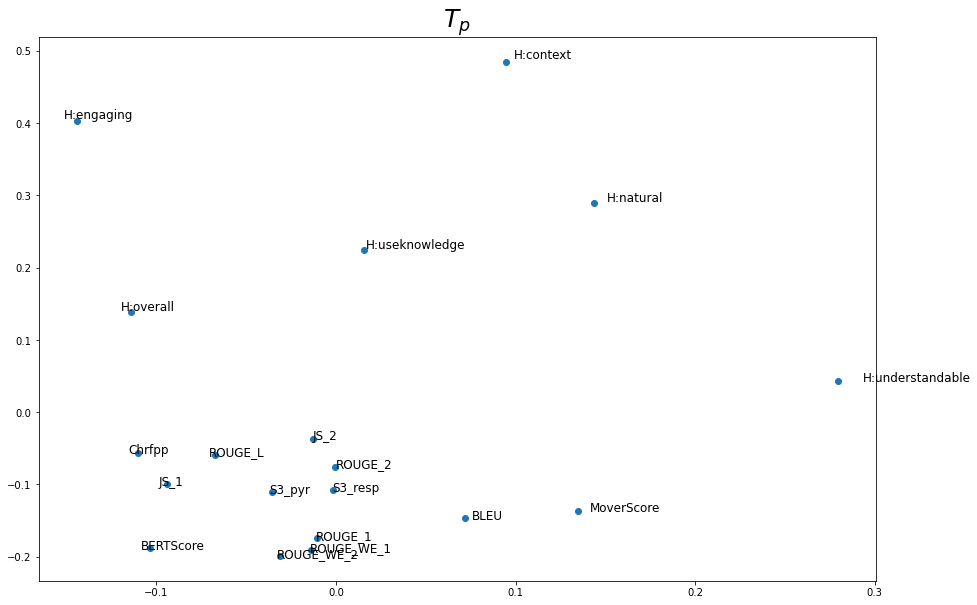

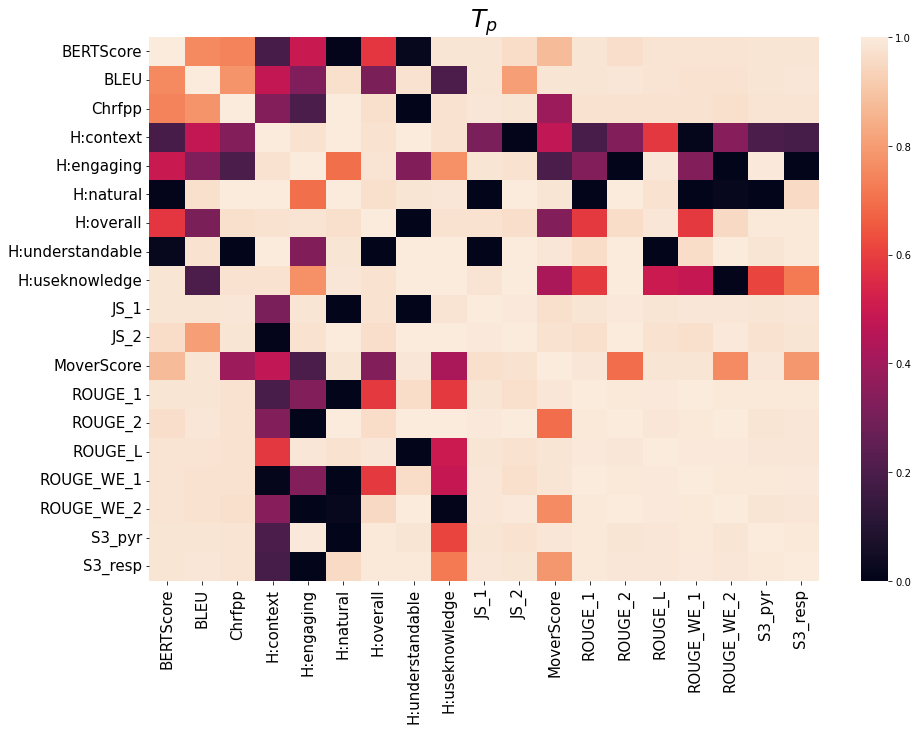

0.2831361346903257
0.2870759264271151
0.07258114509758277
-0.23095657359814323
-0.3457647172295256
-0.5304481213454516
-0.016927958585109853
-0.5277741966949955
-0.34847274455054983
-0.029706866723199273
0.1449850580466521
0.23198117715686276
0.26289835712326215
-0.19016067523049363
0.09686551386055701
0.2190041438534577
0.10062002593790113
0.26330947687136214
0.2577548948923901


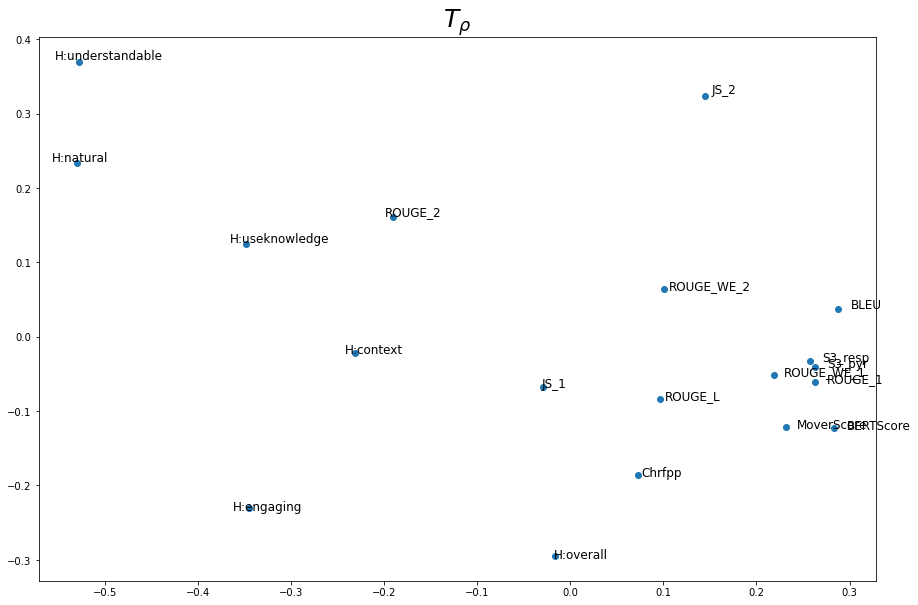

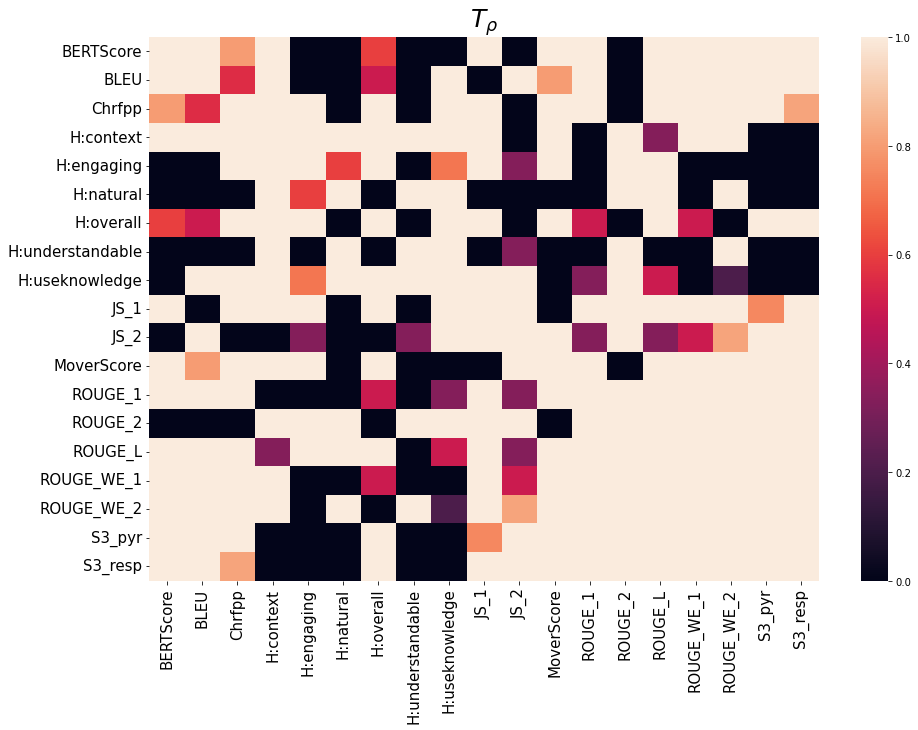

0.28464584239504626
0.08432024809871845
-0.25511744559232813
-0.3874952623062008
0.7071624500363478
0.532352435274742
0.0005744672855506061
-0.7335100288518617
0.3985649167169483
0.6127306645222408
-0.01760446181681064
0.6534297595518136
-0.2785047921418151
-0.5611517170572362
-0.6033053596318844
0.11625079239941521
-0.23880172838525224
-0.609373049570851
0.2948322690733487


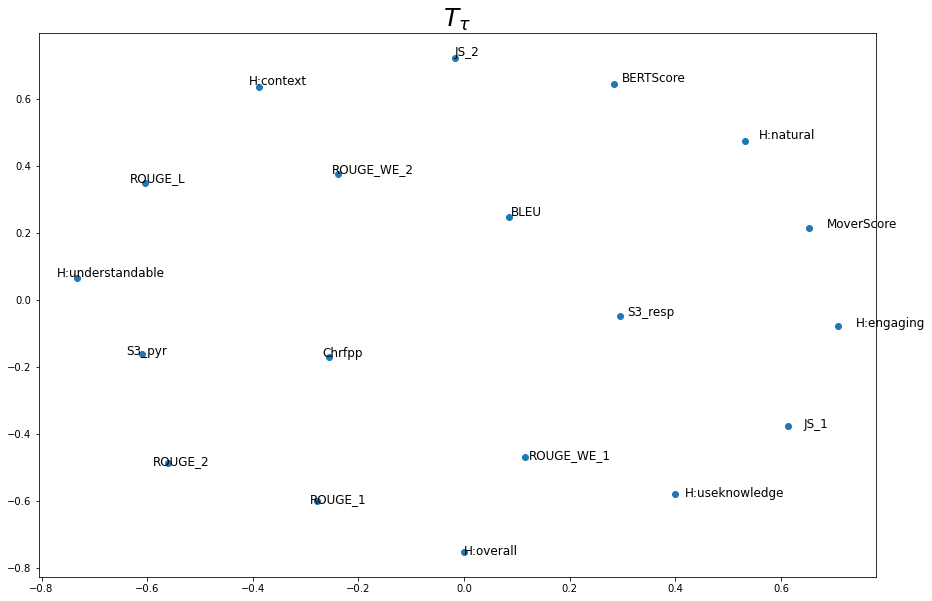

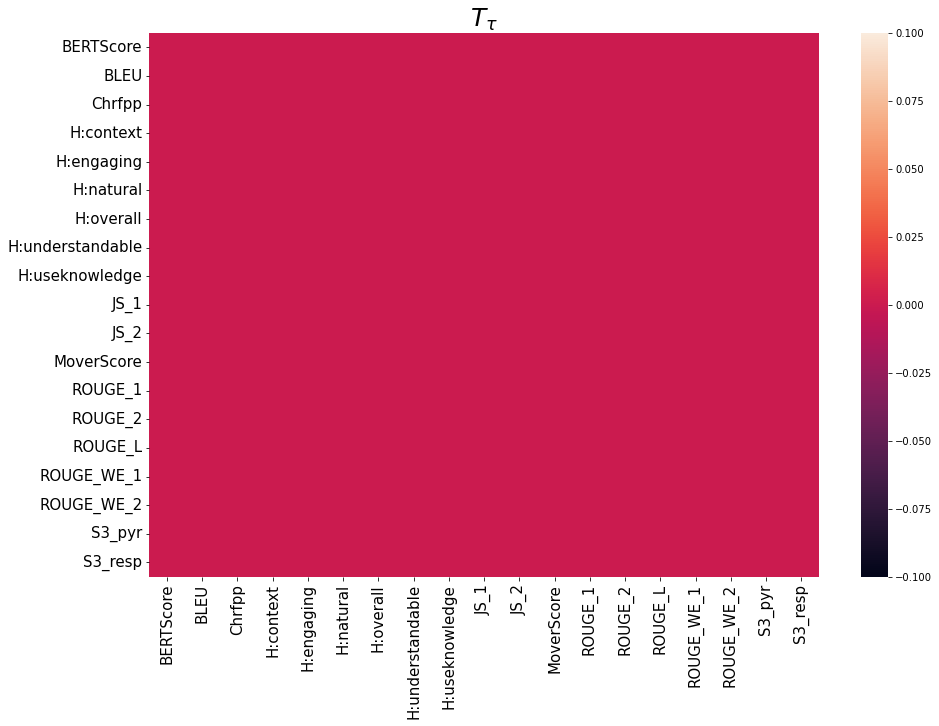

-0.03036231025229233
0.08487996539287006
0.2714554136478518
-0.3540963488809419
-0.05886343009533958
-0.589418293031583
-0.43159565002337175
-0.6299323017822659
-0.7183685331269408
0.35835239836243393
0.4711268976620512
-0.0907546983981601
0.21995750740934678
0.27644853311569945
0.19295268823162903
0.2014676400078723
0.32159572574647577
0.26093516635894154
0.24421962965572339


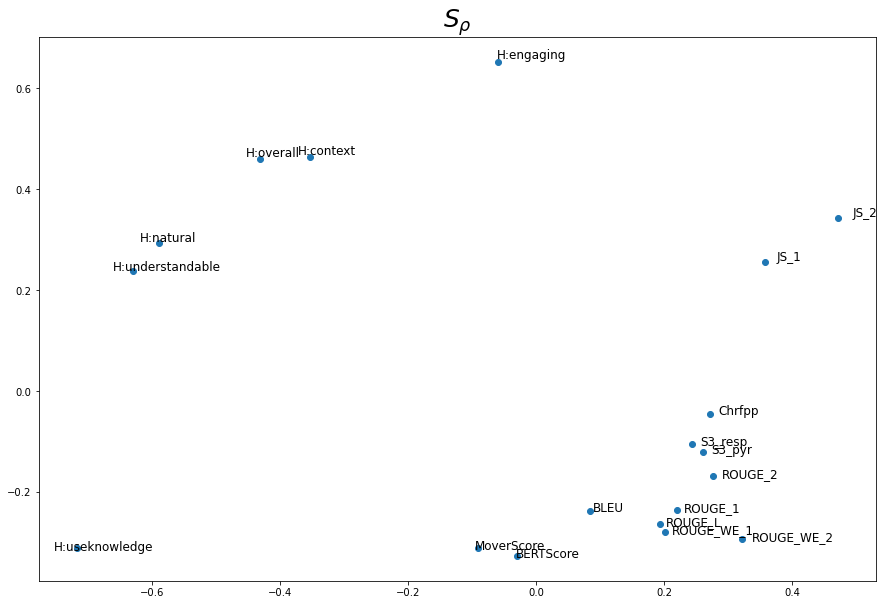

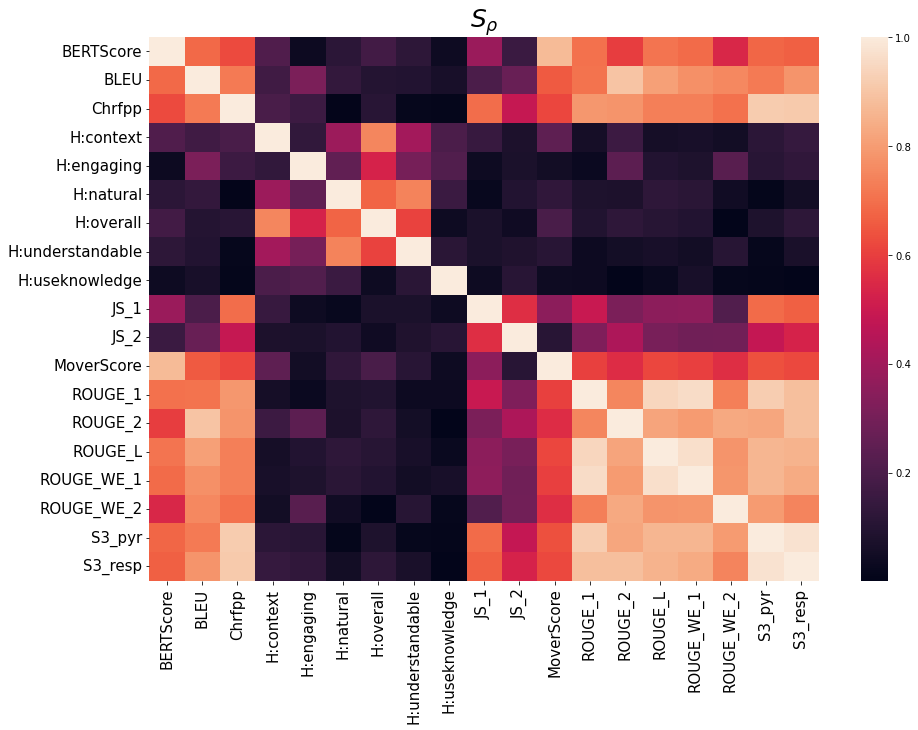

-0.36313740237557557
-0.26248196438445187
-0.13369018964852897
0.21621348837862622
0.4059536148043093
0.6252006410422071
0.5554528251837925
0.6759767178792726
-0.13883227833188894
-0.03522311052805388
0.29622216835767123
-0.46843054324263866
-0.3273845315052969
0.016353942868813795
-0.3747131102064592
-0.34610924277514127
0.05063058974436136
-0.1937131891345447
-0.1982884261264748


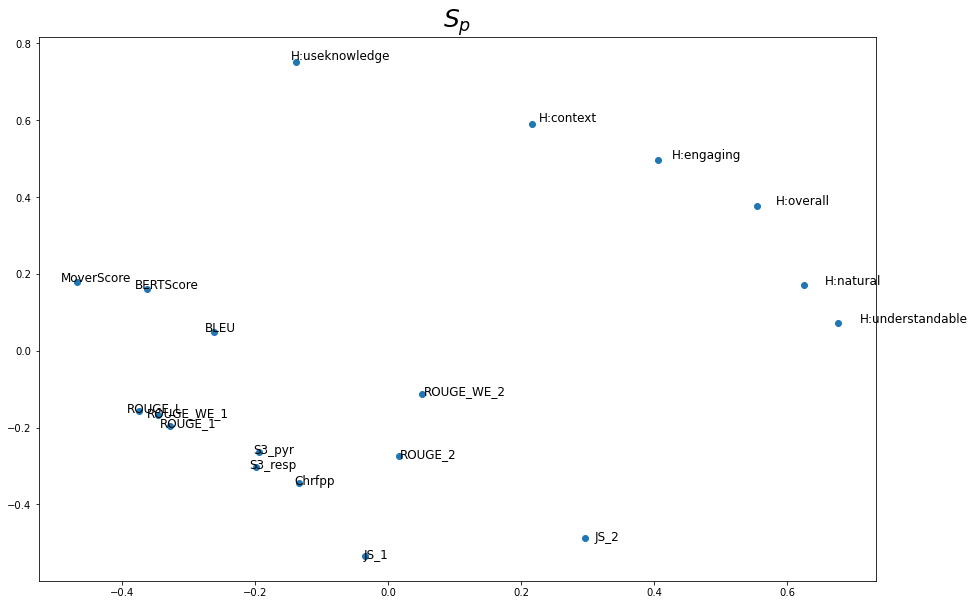

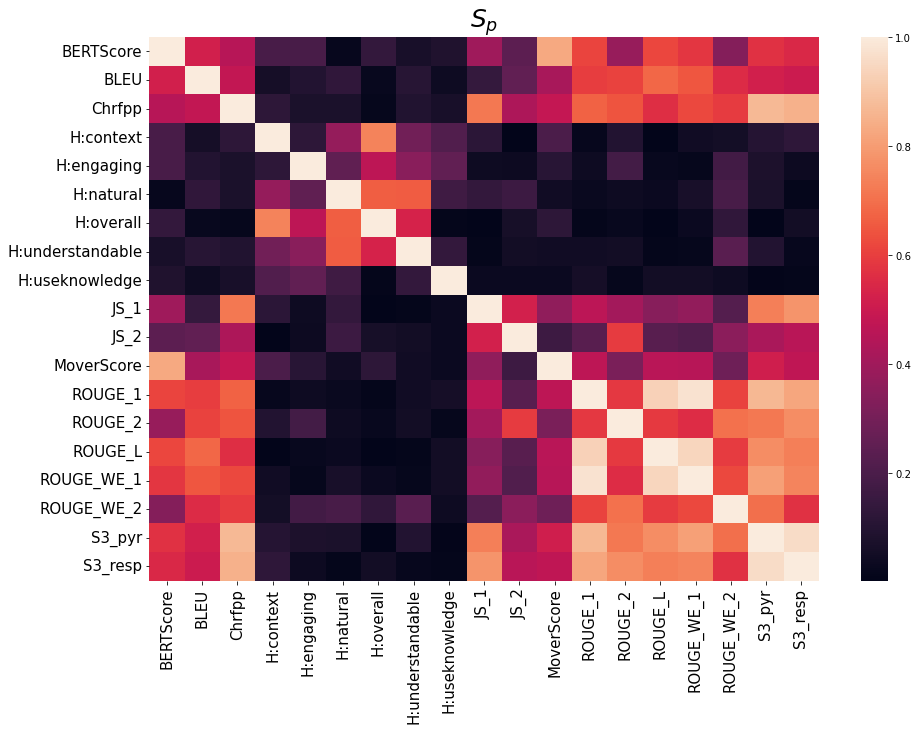

-0.3702488987049971
-0.34036176391980016
0.14011664763185752
-0.13582687292639734
0.1560948779823442
-0.5435459387476942
-0.2903223753426784
-0.451440634885046
0.49227285515643426
0.41519808267658875
0.5914219731380388
-0.4577982345680935
-0.006354795409552135
0.36281198246145047
-0.09467072124762885
-0.03758277489954898
0.2927487187556214
0.10926282295845796
0.16822504989064285


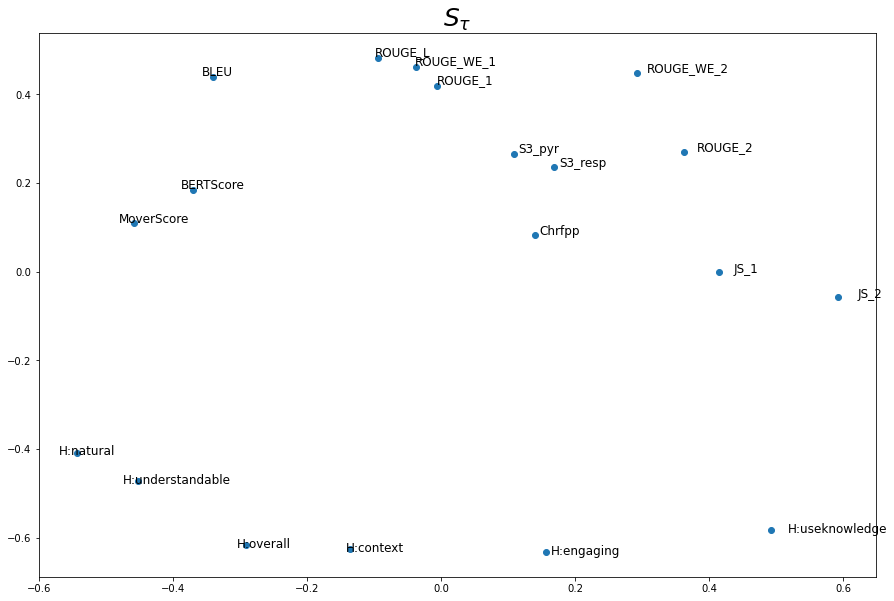

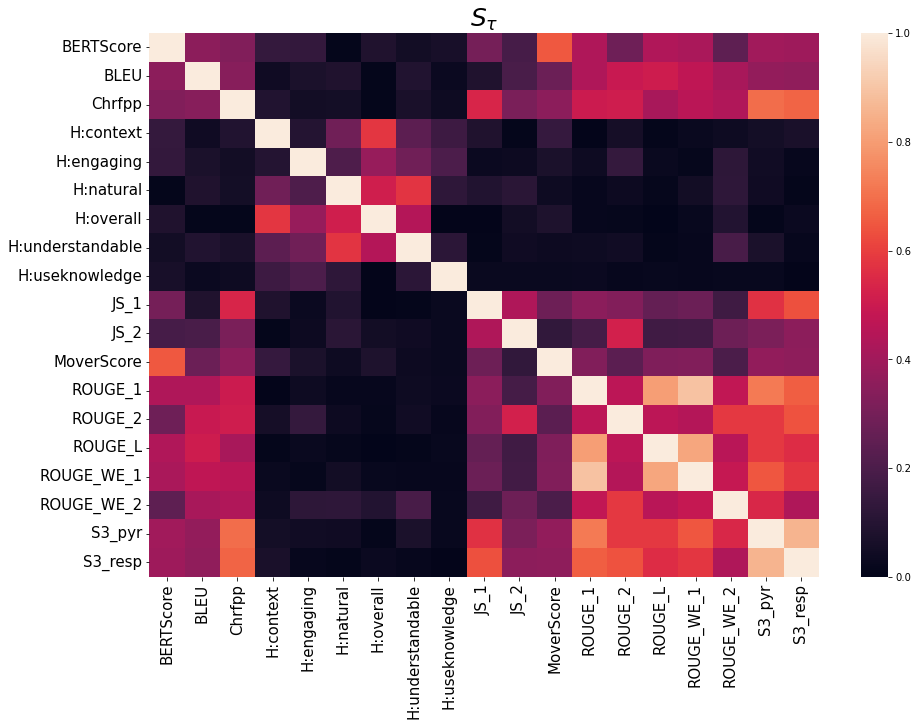

In [165]:
for k,v in final_dic.items():
    m = len(considered_df.columns)
    if 'metric' not in k:
        df_results = pd.DataFrame(final_dic)
        df_results = df_results.pivot("metric_a", "metric_b",k)
        plot_mds(df_results,k)
        plot_heatmap(df_results,k)

        